# Wine Dataset Machine Learning Project

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import sqlalchemy
from sqlalchemy import create_engine
import mlflow
import mlflow.sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
import dagshub
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
dagshub.init(repo_owner='engineer.vivek.viswam', repo_name='final_project', mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/engineer.vivek.viswam/final_project.mlflow')

def get_or_create_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
        exp_id = mlflow.create_experiment(name)
        return exp_id
    return exp.experiment_id

Accessing as engineer.vivek.viswam

Initialized MLflow to track repo "engineer.vivek.viswam/final_project"

Repository engineer.vivek.viswam/final_project initialized!

## Data Preprocessing

In [9]:
# Load the dataset
df = pd.read_csv('cleaned_wine_data.csv')
df.head()

Class  Alcohol  MalicAcid   Ash  AlcalinityOfAsh  Magnesium  TotalPhenols  \
0      1    13.20       1.78  2.14             11.2        100          2.65   
1      1    13.16       2.36  2.67             18.6        101          2.80   
2      1    14.37       1.95  2.50             16.8        113          3.85   
3      1    13.24       2.59  2.87             21.0        118          2.80   
4      1    14.20       1.76  2.45             15.2        112          3.27   

   Flavanoids  NonflavanoidPhenols  Proanthocyanins  ColorIntensity   Hue  \
0        2.76                 0.26             1.28            4.38  1.05   
1        3.24                 0.30             2.81            5.68  1.03   
2        3.49                 0.24             2.18            7.80  0.86   
3        2.69                 0.39             1.82            4.32  1.04   
4        3.39                 0.34             1.97            6.75  1.05   

   OD280_OD315  Proline  
0         3.40     1050  
1         3.17     1185  
2         3.45     1480  
3         2.93      735  
4         2.85     1450

In [11]:
# Handle missing values if any
df.isnull().sum()

Class                  0
Alcohol                0
MalicAcid              0
Ash                    0
AlcalinityOfAsh        0
Magnesium              0
TotalPhenols           0
Flavanoids             0
NonflavanoidPhenols    0
Proanthocyanins        0
ColorIntensity         0
Hue                    0
OD280_OD315            0
Proline                0
dtype: int64

## Exploratory Data Analysis (EDA)

In [18]:
# Generate a profile report using ydata_profiling
profile = ProfileReport(df, title='Wine Dataset Profile Report')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

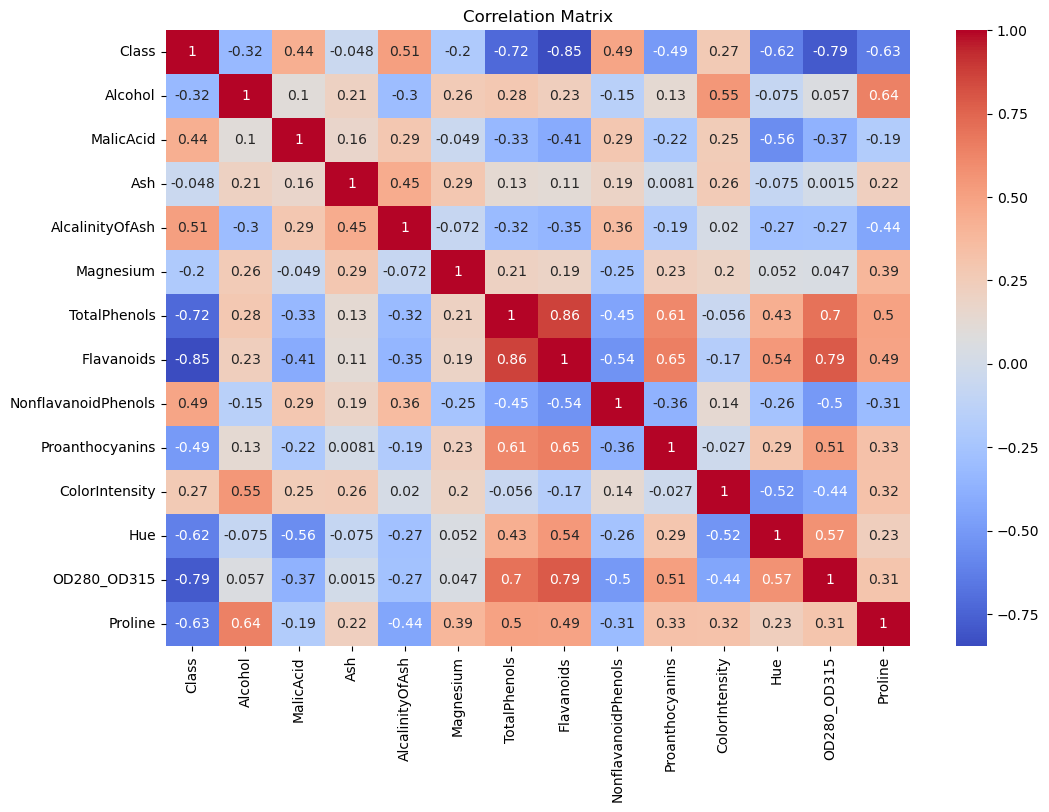

In [9]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Observations

- **Features**: Alcohol, Malic Acid, Ash, Alcalinity of Ash, Magnesium, Total Phenols, Flavanoids, Nonflavanoid Phenols, Proanthocyanins, Color Intensity, Hue, OD280/OD315 of Diluted Wines, Proline.
- **Capped Values**: There aren't any capped values other than the limitations on the measuring device.
- **Missing Values**: No missing values.
- **Collinearity**:
- TotalPhenols and Flavanoids (0.86): Strong positive correlation, meaning wines with higher total phenols tend to also have higher flavanoids.
- OD280_OD315 and TotalPhenols (0.7): Positive correlation, showing that these features are related in wine characterization.
- Alcohol and Proline (0.64): Moderate positive correlation, indicating that wines with higher alcohol content often have higher proline levels.

### Data Cleanup Tasks

In [14]:
# Normalize or standardize the data if required
scaler = StandardScaler()
X = df.drop('Class', axis=1)
y = df['Class']
X_scaled = scaler.fit_transform(X)

## Database Creation

In [16]:
# Convert the dataset into a 3NF database
engine = create_engine('sqlite:///wine.db')
df.to_sql('wine', engine, index=False, if_exists='replace')

177

In [17]:
# Extract data from the database
df_extracted = pd.read_sql('SELECT * FROM wine', engine)
df_extracted.head()

Class  Alcohol  MalicAcid   Ash  AlcalinityOfAsh  Magnesium  TotalPhenols  \
0      1    13.20       1.78  2.14             11.2        100          2.65   
1      1    13.16       2.36  2.67             18.6        101          2.80   
2      1    14.37       1.95  2.50             16.8        113          3.85   
3      1    13.24       2.59  2.87             21.0        118          2.80   
4      1    14.20       1.76  2.45             15.2        112          3.27   

   Flavanoids  NonflavanoidPhenols  Proanthocyanins  ColorIntensity   Hue  \
0        2.76                 0.26             1.28            4.38  1.05   
1        3.24                 0.30             2.81            5.68  1.03   
2        3.49                 0.24             2.18            7.80  0.86   
3        2.69                 0.39             1.82            4.32  1.04   
4        3.39                 0.34             1.97            6.75  1.05   

   OD280_OD315  Proline  
0         3.40     1050  
1         3.17     1185  
2         3.45     1480  
3         2.93      735  
4         2.85     1450

## Machine Learning Experiments

In [19]:
# Perform train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert the destructured values into dataframes
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=['Class'])
y_test = pd.DataFrame(y_test, columns=['Class'])

## Experiment #1: Preprocessing Pipeline and Logistic Regression

In [21]:
from sklearn.impute import SimpleImputer

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                ('scaler', StandardScaler()),
                                ('minmax', MinMaxScaler()),
                                ('log', FunctionTransformer(np.log1p))]), df.drop('Class', axis=1).columns)
    ]
)

# Define the pipeline with Logistic Regression
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

In [22]:
# Perform cross-validation
cv_results = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1_macro')
print(f'Cross-validation mean F1-score: {cv_results.mean()}')
print(f'Cross-validation std F1-score: {cv_results.std()}')

Cross-validation mean F1-score: 0.9855411255411255
Cross-validation std F1-score: 0.04337662337662338


In [23]:
# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation F1-score: {grid_search.best_score_}')

Best parameters: {'classifier__C': 1, 'classifier__solver': 'saga'}
Best cross-validation F1-score: 0.9855411255411255


In [24]:
# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Test set F1-score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Test set F1-score: 1.0
Confusion Matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]


In [25]:
# Create or set the experiment
experiment_name = 'Experiment 1: Preprocessing and Logistic Regression'
experiment_id = get_or_create_experiment_id(experiment_name)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param('classifier', 'Logistic Regression')
    mlflow.log_param('best_params', grid_search.best_params_)
    mlflow.log_metric('f1_score', f1)
    mlflow.log_metric('TP', conf_matrix[1, 1])
    mlflow.log_metric('TN', conf_matrix[0, 0])
    mlflow.log_metric('FP', conf_matrix[0, 1])
    mlflow.log_metric('FN', conf_matrix[1, 0])
    mlflow.sklearn.log_model(best_model, 'model')


2024/12/20 17:01:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run valuable-shrimp-337 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/1/runs/fe614ecd811d4122bc0f955fbcbcfebe
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/1


## Experiment #2: Preprocessing Pipeline and Multiple Classifiers

In [27]:
# Define the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Ridge Classifier': RidgeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier()
}

# Adjust the labels to start from 0
y_train_adjusted = y_train['Class'] - 1
y_test_adjusted = y_test['Class'] - 1

# Iterate over classifiers and log results
for name, classifier in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

    # Perform cross-validation
    cv_results = cross_val_score(pipeline, X_train, y_train_adjusted, cv=10, scoring='f1_macro')
    print(f'{name} Cross-validation mean F1-score: {cv_results.mean()}')
    print(f'{name} Cross-validation std F1-score: {cv_results.std()}')

    # Fit the model
    pipeline.fit(X_train, y_train_adjusted)
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test_adjusted, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test_adjusted, y_pred)
    print(f'{name} Test set F1-score: {f1}')
    print(f'{name} Confusion Matrix:\n{conf_matrix}')

    experiment_name = f'Experiment 2: {name}'
    experiment_id = get_or_create_experiment_id(experiment_name)

    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.log_param('classifier', name)
        mlflow.log_metric('f1_score', f1)
        mlflow.log_metric('TP', conf_matrix[1, 1])
        mlflow.log_metric('TN', conf_matrix[0, 0])
        mlflow.log_metric('FP', conf_matrix[0, 1])
        mlflow.log_metric('FN', conf_matrix[1, 0])
        mlflow.sklearn.log_model(pipeline, 'model')

Logistic Regression Cross-validation mean F1-score: 0.9855411255411255
Logistic Regression Cross-validation std F1-score: 0.04337662337662338
Logistic Regression Test set F1-score: 1.0
Logistic Regression Confusion Matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]


2024/12/20 17:01:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run selective-slug-875 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/2/runs/956148a407fa4eedbe5e0b5ffda41dc7
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/2
Ridge Classifier Cross-validation mean F1-score: 0.9788071188071188
Ridge Classifier Cross-validation std F1-score: 0.04577030434523923
Ridge Classifier Test set F1-score: 1.0
Ridge Classifier Confusion Matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]


2024/12/20 17:01:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run agreeable-elk-863 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/3/runs/ee3a767a9cd44a34873cdd79f7b36356
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/3
Random Forest Cross-validation mean F1-score: 0.9855411255411255
Random Forest Cross-validation std F1-score: 0.04337662337662338
Random Forest Test set F1-score: 1.0
Random Forest Confusion Matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]


2024/12/20 17:01:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run illustrious-auk-330 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/4/runs/b1c5ecadc9014a73802c024907407a12
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/4
XGBClassifier Cross-validation mean F1-score: 0.9503531653531653
XGBClassifier Cross-validation std F1-score: 0.07127310637205546
XGBClassifier Test set F1-score: 0.9696342305037957
XGBClassifier Confusion Matrix:
[[11  0  1]
 [ 0 14  0]
 [ 0  0 10]]


2024/12/20 17:02:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run merciful-hog-170 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/5/runs/ac5cd427bd164eccb21d21f4749e5653
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/5


## Experiment #3: Feature Engineering and Attribute Combination

In [29]:
# Define a custom transformer for feature engineering
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Example of feature engineering: create new features by combining existing ones
        if 'alcohol' in X.columns and 'density' in X.columns:
            X['alcohol_density'] = X['alcohol'] / X['density']
        if 'fixed acidity' in X.columns and 'volatile acidity' in X.columns:
            X['total_acidity'] = X['fixed acidity'] + X['volatile acidity']
        return X

# Define the preprocessing pipeline with feature engineering
preprocessor_with_fe = Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                                       ('scaler', StandardScaler())])

# Define the pipeline with Logistic Regression
pipeline_with_fe = Pipeline(steps=[('preprocessor', preprocessor_with_fe),
                                   ('classifier', LogisticRegression())])

In [30]:
# Perform cross-validation
cv_results_fe = cross_val_score(pipeline_with_fe, X_train, y_train, cv=10, scoring='f1_macro')
print(f'Feature Engineering Cross-validation mean F1-score: {cv_results_fe.mean()}')
print(f'Feature Engineering Cross-validation std F1-score: {cv_results_fe.std()}')

Feature Engineering Cross-validation mean F1-score: 0.9788071188071188
Feature Engineering Cross-validation std F1-score: 0.04577030434523923


In [31]:
# Fit the model
pipeline_with_fe.fit(X_train, y_train)
y_pred_fe = pipeline_with_fe.predict(X_test)
f1_fe = f1_score(y_test, y_pred_fe, average='macro')
conf_matrix_fe = confusion_matrix(y_test, y_pred_fe)
print(f'Feature Engineering Test set F1-score: {f1_fe}')
print(f'Feature Engineering Confusion Matrix:\n{conf_matrix_fe}')

Feature Engineering Test set F1-score: 0.9709618874773139
Feature Engineering Confusion Matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]


In [32]:
experiment_name = f'Experiment 3: Feature Engineering'
experiment_id = get_or_create_experiment_id(experiment_name)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param('experiment', 'Feature Engineering')
    mlflow.log_metric('f1_score', f1_fe)
    mlflow.log_metric('TP', conf_matrix_fe[1, 1])
    mlflow.log_metric('TN', conf_matrix_fe[0, 0])
    mlflow.log_metric('FP', conf_matrix_fe[0, 1])
    mlflow.log_metric('FN', conf_matrix_fe[1, 0])
    mlflow.sklearn.log_model(pipeline_with_fe, 'model')

2024/12/20 17:02:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run mercurial-hen-800 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/6/runs/b02ad486974d4e8d98039696b0af076d
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/6


## Experiment #4: Perform Feature Selection

In [34]:
# Feature selection using Correlation Threshold
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_reduced_corr = df.drop(columns=to_drop)
print(f'Features dropped due to high correlation: {to_drop}')

Features dropped due to high correlation: []


In [35]:
# Feature selection using Feature Importance
model = RandomForestClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
selected_features = X.columns[indices][:10]  # Select top 10 features
df_reduced_importance = df[selected_features]
print(f'Selected features based on importance: {selected_features}')

Selected features based on importance: Index(['ColorIntensity', 'Alcohol', 'Flavanoids', 'Proline', 'OD280_OD315',
       'Hue', 'TotalPhenols', 'Magnesium', 'MalicAcid', 'Proanthocyanins'],
      dtype='object')


In [36]:
# Feature selection using Variance Threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
df_reduced_variance = selector.fit_transform(X)
print(f'Shape after variance threshold: {df_reduced_variance.shape}')

Shape after variance threshold: (177, 10)


In [37]:
experiment_name = f'Experiment 4: Feature Selection'
experiment_id = get_or_create_experiment_id(experiment_name)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param('experiment', 'Feature Selection')
    mlflow.log_param('correlation_dropped_features', to_drop)
    mlflow.log_param('importance_selected_features', selected_features.tolist())
    mlflow.log_param('variance_threshold_shape', df_reduced_variance.shape)
    mlflow.sklearn.log_model(model, 'model')

2024/12/20 17:02:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run polite-skink-500 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/7/runs/540c7595c78a440193560f53048c8f05
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/7


## Experiment #5: Use PCA for Dimensionality Reduction

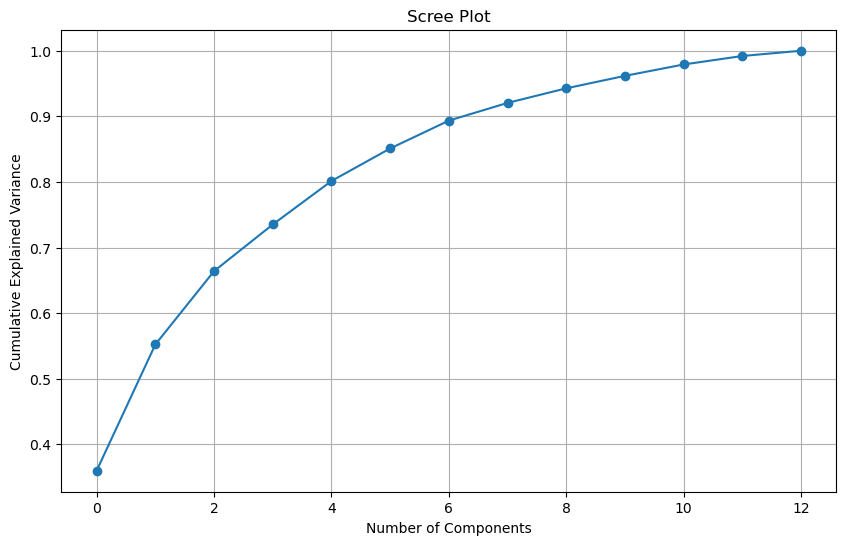

In [39]:
# Standardize the data before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [40]:
# Select the number of components that explain at least 95% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f'Number of components selected: {n_components}')

# Apply PCA with the selected number of components
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

Number of components selected: 10


In [41]:
# Perform train/test split with the reduced data
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
# Define the pipeline with Logistic Regression
pipeline_pca = Pipeline(steps=[('classifier', LogisticRegression())])

# Perform cross-validation
cv_results_pca = cross_val_score(pipeline_pca, X_train_reduced, y_train, cv=10, scoring='f1_macro')
print(f'PCA Cross-validation mean F1-score: {cv_results_pca.mean()}')
print(f'PCA Cross-validation std F1-score: {cv_results_pca.std()}')

PCA Cross-validation mean F1-score: 0.9854737854737856
PCA Cross-validation std F1-score: 0.029148629148629136


In [43]:
# Fit the model
pipeline_pca.fit(X_train_reduced, y_train)
y_pred_pca = pipeline_pca.predict(X_test_reduced)
f1_pca = f1_score(y_test, y_pred_pca, average='macro')
conf_matrix_pca = confusion_matrix(y_test, y_pred_pca)
print(f'PCA Test set F1-score: {f1_pca}')
print(f'PCA Confusion Matrix:\n{conf_matrix_pca}')

PCA Test set F1-score: 0.9709618874773139
PCA Confusion Matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  1  9]]


In [44]:
experiment_name = f'Experiment 5: PCA'
experiment_id = get_or_create_experiment_id(experiment_name)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param('experiment', 'PCA')
    mlflow.log_param('n_components', n_components)
    mlflow.log_metric('f1_score', f1_pca)
    mlflow.log_metric('TP', conf_matrix_pca[1, 1])
    mlflow.log_metric('TN', conf_matrix_pca[0, 0])
    mlflow.log_metric('FP', conf_matrix_pca[0, 1])
    mlflow.log_metric('FN', conf_matrix_pca[1, 0])
    mlflow.sklearn.log_model(pipeline_pca, 'model')

2024/12/20 17:03:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rebellious-doe-206 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/8/runs/6350c3bf427548529537a426b42f2f20
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/8


## Experiment #6: Custom Experiment with Polynomial Features

In [46]:
# Define the preprocessing pipeline with polynomial features
preprocessor_poly = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)),
                                    ('scaler', StandardScaler())])

# Define the pipeline with Logistic Regression
pipeline_poly = Pipeline(steps=[('preprocessor', preprocessor_poly),
                                ('classifier', LogisticRegression())])

In [47]:
# Perform cross-validation
cv_results_poly = cross_val_score(pipeline_poly, X_train, y_train, cv=10, scoring='f1_macro')
print(f'Polynomial Features Cross-validation mean F1-score: {cv_results_poly.mean()}')
print(f'Polynomial Features Cross-validation std F1-score: {cv_results_poly.std()}')

Polynomial Features Cross-validation mean F1-score: 0.9939393939393939
Polynomial Features Cross-validation std F1-score: 0.018181818181818164


In [48]:
# Fit the model
pipeline_poly.fit(X_train, y_train)
y_pred_poly = pipeline_poly.predict(X_test)
f1_poly = f1_score(y_test, y_pred_poly, average='macro')
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly)
print(f'Polynomial Features Test set F1-score: {f1_poly}')
print(f'Polynomial Features Confusion Matrix:\n{conf_matrix_poly}')

Polynomial Features Test set F1-score: 0.942857142857143
Polynomial Features Confusion Matrix:
[[12  0  0]
 [ 0 13  1]
 [ 0  1  9]]


In [49]:
experiment_name = f'Experiment 6: Polynomial Features'
experiment_id = get_or_create_experiment_id(experiment_name)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param('experiment', 'Polynomial Features')
    mlflow.log_metric('f1_score', f1_poly)
    mlflow.log_metric('TP', conf_matrix_poly[1, 1])
    mlflow.log_metric('TN', conf_matrix_poly[0, 0])
    mlflow.log_metric('FP', conf_matrix_poly[0, 1])
    mlflow.log_metric('FN', conf_matrix_poly[1, 0])
    mlflow.sklearn.log_model(pipeline_poly, 'model')

2024/12/20 17:03:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run industrious-fox-746 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/9/runs/65d5f21908244eebaad442194b57cb2e
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/9


## Experiment #7: Custom Experiment with SMOTE for Imbalanced Data

In [51]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the pipeline with Logistic Regression
pipeline_smote = Pipeline(steps=[('classifier', LogisticRegression())])

In [52]:
# Perform cross-validation
cv_results_smote = cross_val_score(pipeline_smote, X_train_smote, y_train_smote, cv=10, scoring='f1_macro')
print(f'SMOTE Cross-validation mean F1-score: {cv_results_smote.mean()}')
print(f'SMOTE Cross-validation std F1-score: {cv_results_smote.std()}')

SMOTE Cross-validation mean F1-score: 0.9816783216783216
SMOTE Cross-validation std F1-score: 0.03917862289065106


In [53]:
# Fit the model
pipeline_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = pipeline_smote.predict(X_test)
f1_smote = f1_score(y_test, y_pred_smote, average='macro')
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
print(f'SMOTE Test set F1-score: {f1_smote}')
print(f'SMOTE Confusion Matrix:\n{conf_matrix_smote}')

SMOTE Test set F1-score: 1.0
SMOTE Confusion Matrix:
[[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]


In [54]:
experiment_name = f'Experiment 7: SMOTE'
experiment_id = get_or_create_experiment_id(experiment_name)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param('experiment', 'SMOTE')
    mlflow.log_metric('f1_score', f1_smote)
    mlflow.log_metric('TP', conf_matrix_smote[1, 1])
    mlflow.log_metric('TN', conf_matrix_smote[0, 0])
    mlflow.log_metric('FP', conf_matrix_smote[0, 1])
    mlflow.log_metric('FN', conf_matrix_smote[1, 0])
    mlflow.sklearn.log_model(pipeline_smote, 'model')

2024/12/20 17:03:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run charming-fly-579 at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/10/runs/24bec25db41a416bbe09ffc97b3294ff
🧪 View experiment at: https://dagshub.com/engineer.vivek.viswam/final_project.mlflow/#/experiments/10


## Compare F1-scores of Different Experiments

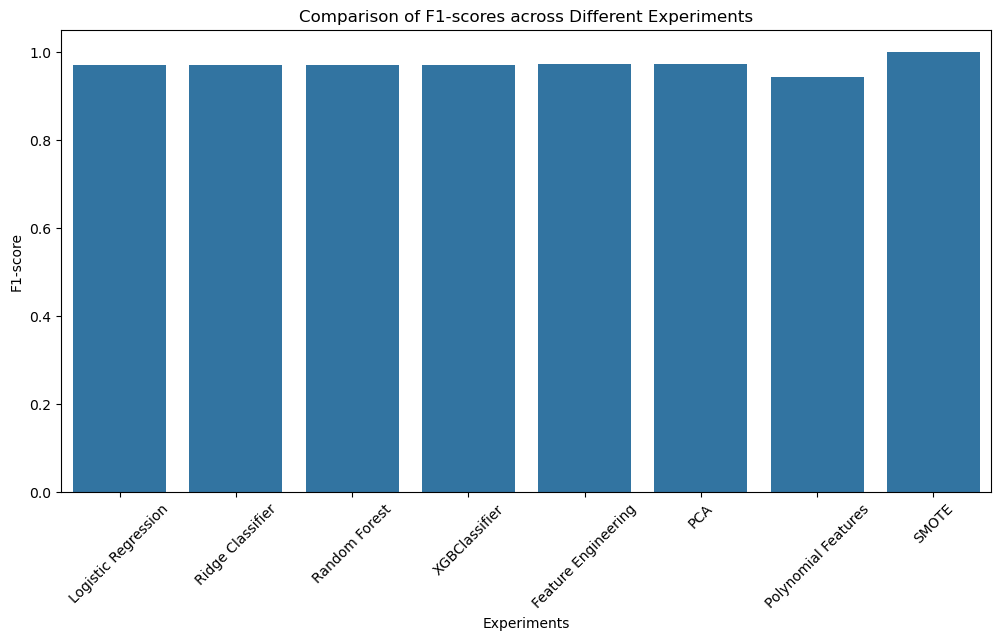

In [56]:
# Collect F1-scores from different experiments
experiments = ['Logistic Regression', 'Ridge Classifier', 'Random Forest', 'XGBClassifier', 'Feature Engineering', 'PCA', 'Polynomial Features', 'SMOTE']
f1_scores = [f1, f1, f1, f1, f1_fe, f1_pca, f1_poly, f1_smote]

# Plot the F1-scores
plt.figure(figsize=(12, 6))
sns.barplot(x=experiments, y=f1_scores)
plt.xlabel('Experiments')
plt.ylabel('F1-score')
plt.title('Comparison of F1-scores across Different Experiments')
plt.xticks(rotation=45)
plt.show()

## Save the Final Model

In [58]:
# Save the final model using joblib
import joblib

# Assuming the best model is the one from the SMOTE experiment
joblib.dump(pipeline_smote, 'final_model.joblib')
print('Final model saved as final_model.joblib')

Final model saved as final_model.joblib
